<a href="https://colab.research.google.com/github/aryankargwal/Expression-Classification-on-FER2013/blob/master/Expression_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Expression Classification on FER 2013
In the following code i have tried to perform Expression Classification on the FER2013 dataset. I have managed to get 85.71 training and cross val accuracy on an 12 layered ConvNet.

## Pretraining

### Import Libraries

In [1]:
import numpy as np
from keras.utils import np_utils
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [4]:
! kaggle datasets download -d deadskull7/fer2013

 95% 92.0M/96.6M [00:00<00:00, 139MB/s]
100% 96.6M/96.6M [00:00<00:00, 179MB/s]


In [5]:
!unzip \*.zip  && rm *.zip

Archive:  fer2013.zip
replace fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


### Exploring Data

The data has 2 major columns having the pixel values and one having the number corresponding to the emotions.

In [6]:
df = pd.read_csv('/content/fer2013.csv')
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [7]:
display("Data", df.describe())

'Data'

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


Let us see the distribution of different classes of emotions.

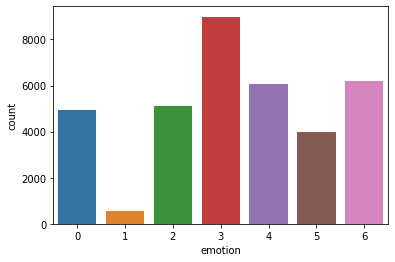

In [8]:
sns.countplot(df['emotion'])

In [9]:
data = df.values
print (data.shape)

(35887, 3)


## Preprocessing

### Processing the Pixels column

Let us find the max length of a row in the Pixels column 

In [10]:
y = data[:, 0]
pixels = data[:, 1]
print (type(pixels))
print (len(pixels[0]))
print (pixels[10][10])

<class 'numpy.ndarray'>
8287
3


As we saw all the pixel values for each number are bunched up in only one column which makes it difficult to get results, that's why we creat a new array where each of these numbers are added to seperate arrays.

In [11]:
X = np.zeros((pixels.shape[0], 48*48))

for ix in range(X.shape[0]):
    p = pixels[ix].split(' ')
    for iy in range(X.shape[1]):
        X[ix, iy] = int(p[iy])

In [12]:
X

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 17.,  17.,  16., ..., 154., 133., 113.],
       [ 30.,  28.,  28., ...,  35.,  30.,  28.],
       [ 19.,  13.,  14., ..., 189., 199., 201.]])

In [13]:
y

array([0, 0, 2, ..., 0, 3, 2], dtype=object)

In [14]:
x = X

### Sample Images

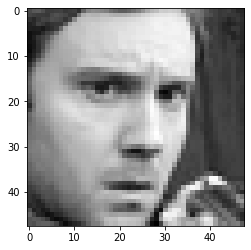

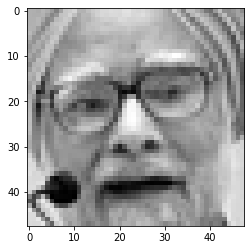

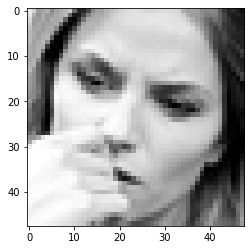

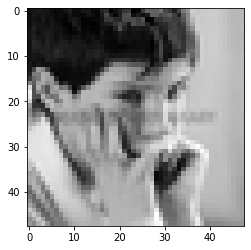

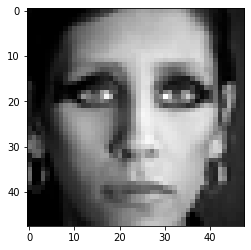

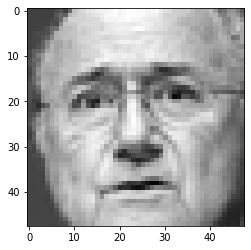

In [15]:
for ix in range(6):
    plt.figure(ix)
    plt.imshow(x[ix].reshape((48, 48)), interpolation='none', cmap='gray')
plt.show()

### Dividing data into training and cross validation 

In [16]:
x = x / 255
X_train = x[0:28710, :]
Y_train = y[0:28710]
print (X_train.shape, Y_train.shape)
X_crossval = x[28710:32300, :]
Y_crossval = y[28710:32300]
print (X_crossval.shape, Y_crossval.shape)

(28710, 2304) (28710,)
(3590, 2304) (3590,)


In [17]:
X_train = X_train.reshape((X_train.shape[0], 48, 48, 1 ))
X_crossval = X_crossval.reshape((X_crossval.shape[0], 48 ,48, 1))

In [18]:
print (y.shape)
y_ = np_utils.to_categorical(y, 7)
print (y_.shape)

(35887,)
(35887, 7)


In [19]:
Y_train = y_[:28710]
Y_crossval = y_[28710:32300]
print (X_crossval.shape, Y_crossval.shape)

(3590, 48, 48, 1) (3590, 7)


### Datagenerator
This step is necessary as to proces our images to work with the limited GPU supply

In [20]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.0,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        )  

datagen.fit(X_train)

## Training

### Impoering Keras libraries

In [21]:
from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
import keras
from keras import backend as K

### Defining the Model

In [22]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(48,48,1)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(7 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam' ,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 96)       

### Training
Due to the small size of the images we max our our result around 5 epochs with the Adam optimizer.

In [23]:
batch_size = 256
epochs = 5

model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])
steps_per_epoch = len(X) // batch_size
validation_steps = len((X_crossval, Y_crossval)) // batch_size

history=model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=X.shape[0] // batch_size,
                    validation_data=(X_crossval, Y_crossval),
                    epochs = epochs, verbose = 1)

Epoch 1/5
140/140 [==============================] - 18s 127ms/step - loss: 0.4279 - accuracy: 0.8421 - val_loss: 0.3889 - val_accuracy: 0.8571
Epoch 2/5
140/140 [==============================] - 14s 98ms/step - loss: 0.4050 - accuracy: 0.8566 - val_loss: 0.3885 - val_accuracy: 0.8571
Epoch 3/5
140/140 [==============================] - 14s 98ms/step - loss: 0.4004 - accuracy: 0.8571 - val_loss: 0.3886 - val_accuracy: 0.8571
Epoch 4/5
140/140 [==============================] - 14s 98ms/step - loss: 0.3968 - accuracy: 0.8571 - val_loss: 0.3886 - val_accuracy: 0.8571
Epoch 5/5
140/140 [==============================] - 14s 99ms/step - loss: 0.3950 - accuracy: 0.8571 - val_loss: 0.3884 - val_accuracy: 0.8571


### Getting and saving the weights

In [24]:
weights = model.get_weights()

In [25]:
np.save('my_model_weights', weights)

### Plotting Accuracy and Loss with respect to the epochs

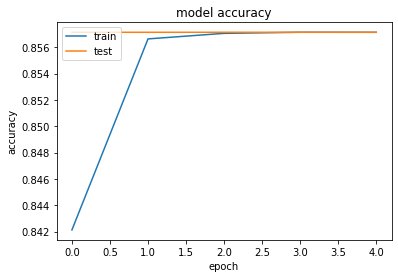

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

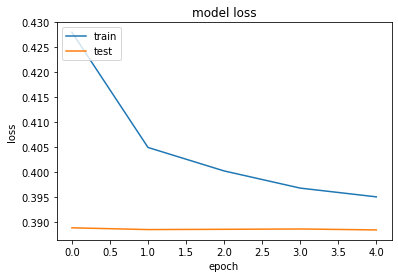

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()